In [3]:
!pip install git+https://github.com/albumentations-team/albumentations.git -q

     |████████████████████████████████| 37.1 MB 47 kB/s 


In [4]:
import torch
import torch.nn as nn

In [5]:
class Encoder(nn.Module):
    def __init__(self, channels=[3, 40, 60, 120, 160, 240], kernel=5, padding=2, pool_kernel=2):
        super().__init__()
        self.conv1 = nn.Conv2d(channels[0], channels[1], kernel, padding=padding)
        self.conv2 = nn.Conv2d(channels[1], channels[2], kernel, padding=padding)
        self.conv3 = nn.Conv2d(channels[2], channels[3], kernel, padding=padding)
        self.conv4 = nn.Conv2d(channels[3], channels[4], kernel, padding=padding)
        self.conv5 = nn.Conv2d(channels[4], channels[5], kernel, padding=padding)
        
        self.relu = nn.ReLU()
        # setting stride to equal kernel
        self.pool = nn.MaxPool2d(pool_kernel, stride=pool_kernel)
    
    def forward(self, x):
        x = self.conv2(self.relu(self.conv1(x)))
        x = self.pool(x)
        x = self.conv4(self.relu(self.conv3(x)))
        x = self.pool(x)
        
        return self.relu(self.conv5(x))
    
class Decoder(nn.Module):
    def __init__(self, channels=[240, 120, 60, 2, 1], kernel=5, padding=2, mid_kernel=2):
        super().__init__()
        self.deconv1 = nn.ConvTranspose2d(channels[0], channels[1], kernel, padding=padding)
        # kernel and stride to match the pool layer in the encoder
        self.deconv2 = nn.ConvTranspose2d(channels[1], channels[2], mid_kernel, stride=mid_kernel)
        self.deconv3 = nn.ConvTranspose2d(channels[2], channels[3], mid_kernel, stride=mid_kernel)
        # for generating output (out channel is 1 mask is one layer)
        self.deconv4 = nn.ConvTranspose2d(channels[3], channels[4], kernel, padding=padding)
    
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.deconv1(x))
        x = self.relu(self.deconv2(x))
        return self.deconv4(self.deconv3(x)).squeeze()

class WickUnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        return self.decoder(self.encoder(x))

# model training

In [6]:
import albumentations as A
import albumentations.augmentations.functional as F
from albumentations.pytorch import ToTensorV2
import cv2
import scipy
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

from collections import defaultdict
import time
import datetime

import matplotlib.pyplot as plt

In [7]:
class ImageDataset(Dataset):
    def __init__(self, image_names, transform, img_size=False):
        self.image_names = image_names
        self.transform = transform
        self.img_size = img_size

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img = cv2.imread(f'/content/drive/MyDrive/prima/{self.image_names[idx]}.tif')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = scipy.sparse.load_npz(f'/content/drive/MyDrive/prima/mask_{self.image_names[idx]}.npz').todense()
        
        transformed = self.transform(image=img, mask=mask)
        
        if self.img_size:
            return transformed["image"], transformed["mask"], img.shape[:2]
        return transformed["image"], transformed["mask"]

In [8]:
# was randomly chosen
training_files = {'00008152', '00008153', '00008150', '00008148', '00325453',
'00008063', '00008230', '00322470', '00325454', '00008332',
'00008062', '00008143', '00008344', '00008141', '00008146',
'00008088', '00008346', '00325450', '00008149', '00008147',
'00325448', '00008227', '00008151', '00322599', '00322596',
'00008334', '00008336', '00008089', '00008229', '00322468',
'00008144', '00008340', '00008061', '00008084', '00325449',
'00322471', '00008140', '00322469', '00008086', '00008145'}

test_files = {'00008228',
 '00322597',
 '00008338',
 '00008064',
 '00322598',
 '00325451',
 '00008142',
 '00325452',
 '00008154',
 '00008342'}

In [9]:
def train(model, dataloader, loss_fun, optimizer):
    total_loss = 0
    total_row = 0

    model.train()

    for img, mask in dataloader:
        img = img.cuda()
        mask = mask.cuda()
        
        pred = model(img)
        loss = loss_fun(pred, mask.float())

        total_loss += loss.item() * img.shape[0]
        total_row += img.shape[0]
                
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (not t % 10) and (t != 0):
        torch.save(model, f'/content/drive/MyDrive/prima/{model_name}_epoch_{t}.pt')

    return total_loss / total_row

def validate(model, dataloader, loss_fun):
    total_loss = 0
    total_row = 0
    
    model.eval()
    
    with torch.no_grad():
        for img, mask in dataloader:
            img = img.cuda()
            mask = mask.cuda()

            pred = model(img)
            loss = loss_fun(pred, mask.float())

            total_loss += loss.item() * img.shape[0]
            total_row += img.shape[0]

    return total_loss / total_row

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

# Training

In [10]:
train_transform = A.Compose(
    [
        
        A.PadIfNeeded(min_height=10296, min_width=7020),
        A.Resize(396, 264),
        ### add here
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
        A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

val_transform = A.Compose(
    [
         A.PadIfNeeded(min_height=10296, min_width=7020),
         A.Resize(396, 264),
         A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
         ToTensorV2()
    ]
)

In [11]:
np.random.seed(511)
train_files = np.random.choice(list(training_files), 35, replace=False).tolist()
val_files = list(training_files.difference(train_files))

In [12]:
batch_size = 16
epoch = 100

In [14]:
train_loss = {}
validation_loss = {}
model_name = '2'

In [15]:
model = WickUnet()
model.cuda()
optimizer = Adam(model.parameters(), lr=0.001)
loss_fun = nn.BCEWithLogitsLoss()

train_ds = ImageDataset(train_files, train_transform)
val_ds = ImageDataset(val_files, val_transform)

train_dl = DataLoader(train_ds, batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size, shuffle=False)


for t in range(epoch):
    start = time.time()
    tl = train(model, train_dl, loss_fun, optimizer)
    train_time = format_time(time.time() - start)

    start = time.time()
    vl = validate(model, val_dl, loss_fun)
    val_time = format_time(time.time() - start)

    train_loss[t] = tl
    validation_loss[t] = vl

    print(f'Epoch: {t}, train_loss: {round(tl, 4)}, train_time: {train_time}, val_loss: {round(vl, 4)}, val_time: {val_time}')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 0, train_loss: 0.6954, train_time: 0:01:43, val_loss: 1.1235, val_time: 0:00:12
Epoch: 1, train_loss: 0.7874, train_time: 0:00:20, val_loss: 0.5905, val_time: 0:00:02
Epoch: 2, train_loss: 0.6448, train_time: 0:00:20, val_loss: 0.522, val_time: 0:00:02
Epoch: 3, train_loss: 0.7705, train_time: 0:00:21, val_loss: 0.6145, val_time: 0:00:02
Epoch: 4, train_loss: 0.6637, train_time: 0:00:20, val_loss: 0.6226, val_time: 0:00:02
Epoch: 5, train_loss: 0.6502, train_time: 0:00:20, val_loss: 0.5464, val_time: 0:00:02
Epoch: 6, train_loss: 0.6218, train_time: 0:00:21, val_loss: 0.5092, val_time: 0:00:02
Epoch: 7, train_loss: 0.6498, train_time: 0:00:20, val_loss: 0.5477, val_time: 0:00:02
Epoch: 8, train_loss: 0.6199, train_time: 0:00:20, val_loss: 0.5224, val_time: 0:00:02
Epoch: 9, train_loss: 0.6054, train_time: 0:00:21, val_loss: 0.5303, val_time: 0:00:02
Epoch: 10, train_loss: 0.5875, train_time: 0:00:20, val_loss: 0.5418, val_time: 0:00:02
Epoch: 11, train_loss: 0.6108, train_time: 

In [16]:
torch.save(model, f'/content/drive/MyDrive/prima/{model_name}_epoch_{t}.pt')

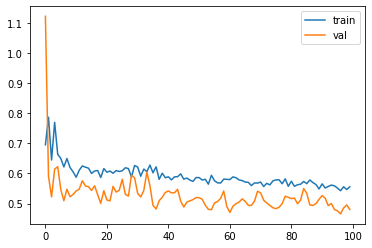

In [17]:
plt.plot(list(train_loss.keys()), list(train_loss.values()), label='train')
plt.plot(list(validation_loss.keys()), list(validation_loss.values()), label='val')
plt.legend()
plt.show()

hi 